# RNN bidireccional

Analizaremos la estructura de una red recurrente bidireccional. Nuestro objetivo será construir un modelo del lenguaje que tome como cadena de entrada una secuencia de palabras $w_1,...,w_T$ y cuya salida sean las probabilidades de las palabras subsecuentes. La idea es que el modelo del lenguaje tome en cuenta todos los estados anteriores, pero tambien los siguientes. Para esto se utiliza la arquitectura bidireccional. De esta forma, estableceremos una probabilidad: 
$$p(w_i|w_1,...,w_{i-1},w_{i+1}...,w_T,)$$

Para realizar esta probabilidad utilizaremos una arquitectura de red neuronal recurrente (RNN) y bidireccional. En primer lugar definiremos algunas funciones para manejar el texto.

In [1]:
#-*- encoding:utf-8 -*-
import numpy as np
from collections import defaultdict, Counter
from itertools import chain

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.split()]

### Procesamiento del corpus

Al igual que con modelos del lenguaje más tradicionales, tomamos un corpus e indexamos las palabras con valores numéricos, con el objetivo de que sea más fácil manejarlas.

In [2]:
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas', 'el perro come', 'el gato come croquetas', 'un gato come']

#Llamamos la funcion para crear el vocabulario
idx = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(corpus,idx))

print(cads_idx)

[[0, 1, 2, 3, 4], [3, 5, 6], [0, 5, 7, 8, 9], [3, 1, 2, 10], [0, 1, 2], [0, 11, 2, 10], [3, 11, 2]]


Además, tenemos que añadir los símbolos de BOS (Beginning Of Sentence) y EOS (End Of Sentence). Estas palabras también se añaden al vocabulario con índices numéricos.

In [3]:
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(idx.values())+2
EOS_IDX = max(idx.values())+1

#Se agregan estas etiqeutas al vocabulario
idx[EOS] = EOS_IDX
idx[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
cadenas = [[BOS_IDX] + cad + [EOS_IDX] for cad in cads_idx]

#Se obtiene la longitud del alfabeto
N = len(idx)

print(idx)

defaultdict(<function vocab.<locals>.<lambda> at 0x7f31466954c0>, {'el': 0, 'perro': 1, 'come': 2, 'un': 3, 'hueso': 4, 'muchacho': 5, 'jugaba': 6, 'saltaba': 7, 'la': 8, 'cuerda': 9, 'croquetas': 10, 'gato': 11, '<EOS>': 12, '<BOS>': 13})


### Bidirectional-RNN

Para construir la RNN bidireccional definiremos una arquitectura simple con celdas vanilla:

1) Incorporaremos una capa de embedding. En esta se tomará un one-hot $s^{(t)}$ que represente a una palabra $w_t$. Definiremos una matriz que guarde los vectores de embedding, $C$ de $d\times N$, donde $d$ es la dimensión de los embeddings y $N$ el tamaño del vocabulario. Así, la capa de embedding estará definida por $$x = Cs^{(t)}$$

2) Las celdas bidireccionales son independientes entre sí (pero dependientes de la entrada y la salida). Por facilidad, ambas celdas tendrán la misma dimensión $m$, pero las matrices que la parámetros que la definen (matrices de pesos y bias) son distintas. La celda de avance se definirá  como:

$$h_{\rightarrow t} = \tanh(V_{\rightarrow}h_{t-1} + U_{\rightarrow}x + b_{\rightarrow})$$

Por su parte, la celda de retroceso será:

$$h_{\leftarrow t} = \tanh(V_{\leftarrow}h_{t+1} + U_{\leftarrow}x + b_{\leftarrow})$$ 

Las celdas de avance y retroceso lucen parecidas, sin embargo, los parámetros seránn distintos; asimismo, la celda de avance tomará la celda en el estado anterior, mientras que la de avance tomará la celda en el estado siguiente..

3) La capa de salida se conformará por la función Softmax. Así, la definimos como $$\phi(x) = Softmax(Wh_t + c)$$

En primer lugar, inicializamos los parámetros de la red.

In [4]:
np.random.seed(0)
#El número de rasgos que representan cada vector
nn_input_dim = N
#El total de clases que arrojará
output_dim = N-1

#Dimensiones de los vectores-palabra
dim = 2
cell_dim = 3

#Embedding
C = np.random.randn(dim,nn_input_dim) / np.sqrt(nn_input_dim)

#Capa oculta
#Celda forward
V_for = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)
#Celda backward
V_back = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)

#Capa oculta, entrada
#Celda forward
U_for = np.random.randn(cell_dim,dim) / np.sqrt(dim)
b_for = np.zeros(cell_dim)

#Celda backward
U_back = np.random.randn(cell_dim,dim) / np.sqrt(dim)
b_back = np.zeros(cell_dim)

#Capa de salida
W = np.random.randn(output_dim,2*cell_dim) / np.sqrt(cell_dim)
c = np.zeros(output_dim)

A continuación, definimos el entrenamiento: la fase de forward y el backpropagation. Utilizamos un rango de aprendizaje (lr) de 0.1 y 100 iteraciones (it).

En este caso, calculamos todas las celdas de avance y retroceso antes de pasar a la siguiente capa. Para hacer de manera sencial, en el retroceso sólo invertimos la cadena, de tal forma que la red recorra la cadena en sentido inverso. Tanto las celdas de avance y retroceso se almacenan en matrices, que serán utilizadas en la capa de salida.

In [5]:
it = 15
lr = 0.1

for t in range(it):
    
    #Avance
    for seq in cadenas:
        #Inicializaciopn de estados
        h_for = np.zeros((len(seq)+1,cell_dim))
        #Inicialización de estados
        h_back = np.zeros((len(seq)+1,cell_dim))
        
        #Avance
        for t,w in enumerate(seq):
            #FORWARD
            #Embedding
            x = C.T[w]
                        
            #VANILLA CELLS
            #Avance
            act_for = np.dot(V_for,h_for[t]) + np.dot(U_for,x) + b_for
            h_for[t+1] = np.tanh(act_for)
              
        #Retroceso
        for t,w in enumerate(seq[::-1]):
            #FORWARD
            #Embedding
            x = C.T[w]
            
            #VANILLA CELLS
            #Retroceso
            act_back = np.dot(V_back,h_back[t]) + np.dot(U_back,x) + b_back
            h_back[t+1] = np.tanh(act_back)
        
        #OPUTPUT & BACKPROP
        for t, w in enumerate(seq):
            #Avance+Retroceso
            h = np.concatenate((h_for[t+1], h_back[t+1]), axis=None)
            
            #capa de salida
            preAct = np.exp(np.dot(W,h) + c)
            #Softmax
            probs = preAct/preAct.sum(0)
            
            #BACK-PROP
            #Variable de salida
            d_out = probs
            if t < len(seq)-1:
                d_out[seq[t+1]] -= 1
            else:
                d_out[EOS_IDX] -= 1
            
            #Variable de celdas
            d_h = (1-h**2)*np.dot(W.T,d_out)
            
            #Variable de embedding
            d_emb = np.dot(U_for.T,d_h[:cell_dim]) + np.dot(U_back.T,d_h[cell_dim:])

            #Jacobianas
            dW = np.outer(d_out,h)
            #Avance
            dV_for = np.outer(d_h[:cell_dim], h_for[t+1])
            dU_for = np.outer(d_h[:cell_dim], x)
            #Retroceso
            dV_back = np.outer(d_h[cell_dim:], h_back[t+1])
            dU_back = np.outer(d_h[cell_dim:], x)

            #Gradientes descendientes
            W -= lr*dW
            c -= lr*d_out
            
            V_for -= lr*dV_for
            V_back -= lr*dV_back
            
            U_for -= lr*dU_for
            b_for -= lr*d_h[:cell_dim]
            U_back -= lr*dU_back
            b_back -= lr*d_h[cell_dim:]
            
            C.T[w] -= lr*d_emb

### Calculo de probabilidades

Una vez entrenado el modelo, definimos una función (forward) que corra la red sobre una cadena de entrada.

In [6]:
def forward(sent, h0_for = np.zeros(cell_dim), h0_back = np.zeros(cell_dim)):
    sent = [idx[i] for i in sent.split()]
    prob_tot = np.zeros((len(sent),N-1))
    
    #Inicializaciopn de estados
    h_for = np.zeros((len(sent)+1,cell_dim))
    #Inicialización de estados
    h_back = np.zeros((len(sent)+1,cell_dim))

    #Asignación de valores iniciales
    h_for[0] = h0_for
    h_back[0] = h0_back

    #Avance
    for t,w in enumerate(sent):
        #FORWARD
        #Embedding
        x = C.T[w]

        #VANILLA CELLS
        #Avance
        act_for = np.dot(V_for,h_for[t]) + np.dot(U_for,x) + b_for
        h_for[t+1] = np.tanh(act_for)

    #Retroceso
    for t,w in enumerate(sent[::-1]):
        #BACKWARD
        #Embedding
        x = C.T[w]

        #VANILLA CELLS
        #Retroceso
        act_back = np.dot(V_back,h_back[t]) + np.dot(U_back,x) + b_back
        h_back[t+1] = np.tanh(act_back)

    #OPUTPUT & BACKPROP
    for t, w in enumerate(sent):
        #Avance+Retroceso
        h = np.concatenate((h_for[t+1], h_back[t+1]), axis=None)

        #capa de salida
        preAct = np.exp(np.dot(W,h) + c)
        #Softmax
        probs = preAct/preAct.sum(0)

        #Se almacenan las probabilidades
        prob_tot[t] = probs
        
    return np.concatenate((h_for,h_back), axis=1), prob_tot       

Finalmente, podemos aplicar la red a una cadena para obtener su probabilidad. Como modelo del lenguaje, podemos aplicar para obtener las probabilidades de transición. Por ejemplo, si la aplicamos al símbolos BOS, obtendremos las probabilidades de que una palabra inicie una cadena.

In [7]:
#Obtenemos las matrices de avance y retroceso asi como vector de probs
H,p = forward('<BOS>')

#Probabilidades iniciales p(w|BOS)
for word, j in idx.items():
    if word != '<BOS>':
        print(word, p[0][j])
        
#Suma igual a 1
print(p[0].sum(0))

el 0.5012979372900094
perro 0.024846168157972845
come 8.633815894655691e-05
un 0.34325029006404306
hueso 0.003818904446129631
muchacho 0.009013087983843142
jugaba 0.0003178361964267705
saltaba 0.0019774410218603104
la 0.00028491209093621587
cuerda 0.00033570131180064183
croquetas 0.0031412186713584483
gato 0.017196161003810675
<EOS> 0.09443400360286232
0.9999999999999999


Asimismo, podemos obtener las probabilidades de una palabra dada las $n$ anteriores, lo que determina un modelo de $n-gramas$. Por ejemplo, podemos obtener probabilidades del tipo $p(w_i|w_{i-1},w_{i-2})$.

In [8]:
#Forward
H,p = forward('el perro')

#Probabilidad de bigramas
for word, j in idx.items():
    if word != '<BOS>':
        print(word, p[1][j])

#Suma igual a 1
print(p[-1].sum(0))

el 9.783450968908839e-05
perro 0.0005589984902912686
come 0.7379091682819992
un 0.000794493644275071
hueso 0.004666398765461557
muchacho 0.0012035776424747086
jugaba 0.019929786869976054
saltaba 0.007640027318894942
la 0.09129820570939207
cuerda 0.06372330366928934
croquetas 0.055622993856730155
gato 0.0013136538521516818
<EOS> 0.015241557389374895
1.0


Más aún, podemos notar que la probabilidad de una cadena completa puede darse como:

$$p(w_1,...,w_T) = \prod_{t=1}^T p(w_t|w_1,...,w_{t-1}, w_{t+1},...,w_{T})$$

In [9]:
def prob_total(string):
    #Agrega símbolo de inicio para prob inicial
    frase = '<BOS> ' + string
    #Aplica la red para obtener probs
    H,p = forward(frase)
    #Inicia probabilidad de cadena
    prob = 1
    #Separa la frase en palabra
    words = frase.split()
    for j in range(len(words)-1):
        #Siguiente palabra
        nxt = words[j+1]
        #Prob de nxt_word dado anteriores
        prob *= p[j][idx[nxt]]
    
    return prob

frase1 = 'el perro come un hueso'
prob1 = prob_total(frase1)
frase2 = 'cuerda gato cuerda la saltaba'
prob2 = prob_total(frase2)
print('Probabilidad cadena "{}" es {}\nProbabilidad cadena "{}" es {}'.format(frase1,prob1, frase2,prob2))

Probabilidad cadena "el perro come un hueso" es 0.0001944208664800472
Probabilidad cadena "cuerda gato cuerda la saltaba" es 2.983827915499057e-11


### Ploteo de los embeddings

Además de obtener una probabilidad de cadenas, el modelo que hemos descrito aprende representaciones vectoriales de la palabra o embeddings. Al igual que el modelo de Word2Vec, podemos ocupar una arquitectura recurrente para obtener embeddings de palabra. Aquí hemos descrito una versión muy sencilla de esto. Modelos más complejos son CoVe (McCann, 2017) o ELMo (Peters et al., 2018).

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from operator import itemgetter

#Funcion para plotear los datos con labels
def plot_words(Z,ids):
    #Reduce la dimensionalidad a 2
    Z = PCA(2).fit_transform(Z)
    
    #Plotea con la marcas (marker) y el color indicado (c)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    #plt.show()

#Ordena las etiquetas para que coincidan con los vectores-renglón de la matriz de embedding
label = [w[0] for w in sorted(idx.items(), key=itemgetter(1))]

Así, la visualización de los datos es la siguiente:

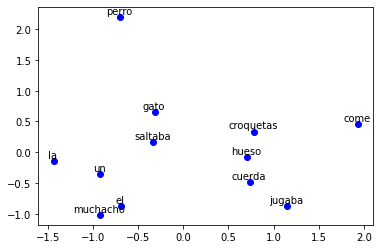

In [11]:
#Ploteo (no se plotean ni BOS ni EOS)
plot_words(C.T[:-2],label)

### Calculo de similitud

Para calcular la similitud entre vectores, se puede utilizar la distancia eculideana o bien el coseno. En NLP el coseno es una forma común de determinar la similitud entre vectores. Este se define como:

$$\cos(x,y) = \frac{x\cdot y}{||x|| ||y||}$$

Asimismo, para simplificar el calculo del coseno se pueden normalizar los vectores, dividiéndolos entre sus normas. Así, para cada vector $x$ su norma es $||x||=1$, lo que simplifica la ecuación anterior a:

$$\cos(x,y) = x\cdot y$$

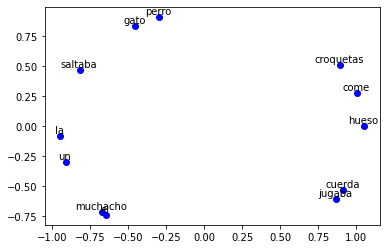

In [12]:
#Normalización de los vecotores
C_norm = (C/np.array([np.linalg.norm(w) for w in C.T])).T

#Ploteo (sin BOS ni EOS)
plot_words(C_norm[:-2],label)

In [13]:
#Palabra objetivo
obj_word = C_norm[idx['perro']]

#Búsqueda de palabras más similares
for w,v in idx.items():
    #Calcula la distancia coseno
    print(w,'\t', np.dot(C_norm[v], obj_word) )

el 	 -0.4280413442158356
perro 	 1.0
come 	 -0.049302273537972674
un 	 0.08003140315050494
hueso 	 -0.31984029084368387
muchacho 	 -0.3944816112340327
jugaba 	 -0.8276821984700844
saltaba 	 0.7677806084037301
la 	 0.29672349323237185
cuerda 	 -0.7742241523531479
croquetas 	 0.21556387795913978
gato 	 0.9849409163733391
<EOS> 	 0.18102105923537354
<BOS> 	 -0.6217893211941313


### Predicción de secuencias

Una aplicación típica de este tipo de modelos es la generación de secuencias; esto tiene aplicaciones, por ejemplo, en la predicción automática de texto, en agentes conversacionales, entre otras. La idea es introducir una secuencia inicial $x^{(1)},...,x^{(t)}$ y que se prediga los elementos subsecuentes. Esto de la forma siguiente:

$$\hat{y}^{(t+1)} = \arg\max_y p(y|x^{(1)},...,x^{(t)})$$

Donde $y$ son los posibles elementos de un alfabeto. En el siguiente estado, $t+2$, se querrá predecir un elemento que siga a la secuencia $x^{(1)},...,x^{(t)}, \hat{y}^{(t+1)}$, por lo que tenemos que calcular:

$$\hat{y}^{(t+2)} = \arg\max_y p(y|x^{(1)},...,x^{(t)}, \hat{y}^{(t+1)})$$

Es decir, el símbolo $\hat{y}^{(t+1)}$ será la entrada de la RNN en el estado siguiente. De manera general, queremos obtener:

$$\hat{y}^{(t+i)} = \arg\max_y p(y|x^{(1)},...,x^{(t)},\hat{y}^{(t+1)}, ..., \hat{y}^{(t+i-1)})$$

La secuencia terminará cuando $\hat{y}^{(t+i)} = EOS$ para alguna $i$.


In [14]:
def forward_prediction(sent):
    #Inicializa la cadena a predecir
    words = []
    
    #Forward (encoding)
    h, probs = forward(sent)
    #Se busca el argumento que maximiza la probabilidad
    arg_max = list(idx.keys())[list(idx.values()).index(np.argmax(probs[-1]))]
    #Se agrega a la cadena
    words.append(arg_max)
    #Nueva h a mandar
    s = (h[-1][:cell_dim] + h[-1][cell_dim:])/2
    
    #Hacer hasta predecir EOS
    while arg_max != '<EOS>':
        #Decoding dado lo predicho anteriormente
        h, probs = forward(arg_max,s, np.zeros(cell_dim))
        #Susttitute la celda codificada
        s = h[-1][:cell_dim]
        #Obtener el argmax 
        arg_max = list(idx.keys())[list(idx.values()).index(np.argmax(probs[-1]))]
        #Se agrega a la cadena predicha
        words.append(arg_max)    
        
    return sent + ' ' + ' '.join(words[:-1])

Definido esta función, podemos autocompletar sentencias:

In [15]:
print( forward_prediction('la') )
print( forward_prediction('el perro') )
print( forward_prediction('un muchacho') )

la cuerda
el perro come un
un muchacho cuerda


Otras aplicaciones de las RNN son la traducción automática, el etiquetado (a diferentes niveles), sistemas de voz a texto y de texto a voz, etc. Sin embargo, en la actualidad se utilizan arquitecturas más compejas, como LSTMs y capas de atención.

### Visualización de las celdas recurrentes

Las celdas recurrentes guardan información tanto de los vectores de entrada como de la red en estados anteriores. Estas celdas tienen información importante que le permite a la red decidir la distribución de salida en un estado dado. Algunos modelos de representación vectorial (word embeddings) han aprovechado la información aquí almacenada para producir vectores de palabraS; sistemas como CoVe toman en cuenta estas celdas para "contextualizar" los embeddings.

Lo primero que haremos es definir un función que, además de devolver la probabilidad de salida, regrese cada una de las celdas recursivas en cada estado $t$. Así, obtendremos una matriz $H$ donde cada renglon será una celda vanilla. Podemos definir esta matriz por sus renglones como:

$$H_{t} = g(Vh^{(t-1)} + Ux^{(t)} + b)$$

En este caso $h^{(t)}$ es la concatenación de las celdas de avance y retroceso en el estado $t$.

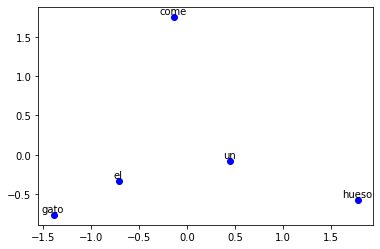

In [16]:
ex_sent = 'el gato come un hueso'
H_s, p_s = forward(ex_sent)

plot_words(H_s[1:],ex_sent.split())
plt.show()

Entonces, dada una cadena, se obtendrá una celda vanilla para cada palabra en la cadena. De esta forma, podemos pensar que esta celda representa a la palabra  y su historia (las palabras que lo anteceden). Podemos visualizarlos, entonces, en un espacio vectorial.

Se puede ver cómo varían las celdas vanillas. Algunas de estas guardan cierta relación. Sin embargo, una interpretación precisa puede resultar complicada.

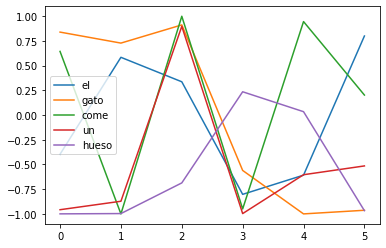

[[-0.39672093  0.58292436  0.33569796 -0.80195358 -0.6079981   0.79829794]
 [ 0.83777978  0.72668122  0.91063261 -0.56030551 -0.99956722 -0.96291632]
 [ 0.64251758 -0.99976082  0.99804802 -0.94956224  0.944095    0.20157455]
 [-0.95725555 -0.87174867  0.89594678 -0.99634639 -0.60362308 -0.51475206]
 [-0.99916084 -0.99625678 -0.68642684  0.23471467  0.03350522 -0.96692069]]


In [17]:
plt.plot(H_s[1:].T, '-')
plt.gca().legend(ex_sent.split())
plt.show()
print(H_s[1:])